In [1]:
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Path to your TensorBoard event file
log_dir = "../tb_logs/dqn_prb_mlp_20251014_110153"  # change this to your folder

# Load the TensorBoard data
ea = event_accumulator.EventAccumulator(log_dir)
ea.Reload()

# Check what scalar tags exist (e.g., 'train/reward', 'rollout/ep_rew_mean')
print(ea.Tags())



2025-10-16 12:36:44.076866: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-16 12:36:44.107800: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI AVX_VNNI_INT8 AVX_NE_CONVERT FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-16 12:36:44.772494: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


{'images': [], 'audio': [], 'histograms': ['actions/hist'], 'scalars': ['cell/bs_1_cell_mid_freq/reward', 'cell/bs_1_cell_mid_freq/reward_ema', 'cell/bs_1_cell_mid_freq/embb_score', 'cell/bs_1_cell_mid_freq/urllc_score', 'cell/bs_1_cell_mid_freq/mmtc_score', 'cell/bs_1_cell_mid_freq/epsilon', 'cell/bs_1_cell_mid_freq/loss', 'cell/bs_1_cell_mid_freq/prb_eMBB', 'cell/bs_1_cell_mid_freq/prb_URLLC', 'cell/bs_1_cell_mid_freq/prb_mMTC', 'cell/bs_1_cell_mid_freq/action_prev', 'cell/bs_1_cell_mid_freq/slice/eMBB/satisfaction', 'cell/bs_1_cell_mid_freq/slice/eMBB/throughput', 'cell/bs_1_cell_mid_freq/slice/eMBB/backlog', 'cell/bs_1_cell_mid_freq/slice/eMBB/oversupply', 'cell/bs_1_cell_mid_freq/slice/eMBB/idle', 'cell/bs_1_cell_mid_freq/slice/eMBB/need', 'cell/bs_1_cell_mid_freq/slice/eMBB/tx_mbps', 'cell/bs_1_cell_mid_freq/slice/eMBB/buf_bytes', 'cell/bs_1_cell_mid_freq/slice/eMBB/prb_req', 'cell/bs_1_cell_mid_freq/slice/eMBB/prb_granted', 'cell/bs_1_cell_mid_freq/slice/URLLC/satisfaction', 'ce

In [6]:
# ==========================================================
# TensorBoard Slice Analysis (Fixed Naming & Filtering)
# ==========================================================
import pandas as pd
from tensorboard.backend.event_processing import event_accumulator

# -------- CONFIGURATION --------
log_dir = "../tb_logs/dqn_prb_arch-lstm_seq8__seq_len-8__seq_hidden-128__move-5__period-1__batch-64__aux-h1__aux-w0.05__horizon-off_20251024_214606"   # your run directory
start_step = 0
end_step = 250_000
base = "cell/bs_1_cell_mid_freq"
slices = ["eMBB", "URLLC", "mMTC", "All"]

# -------- LOAD EVENTS --------
ea = event_accumulator.EventAccumulator(log_dir)
ea.Reload()

# -------- METRICS TO EXTRACT --------
metric_groups = {
    # global metrics
    "reward": [
        f"{base}/reward",
        f"{base}/reward_ema",
        f"{base}/loss",
        f"{base}/epsilon",
        f"{base}/prb_eMBB",
        f"{base}/prb_URLLC",
        f"{base}/prb_mMTC",
    ],
    # per-slice metrics
    "throughput":   [f"{base}/slice/{s}/throughput"   for s in slices],
    "tx_mbps":      [f"{base}/slice/{s}/tx_mbps"      for s in slices],
    "buf_bytes":    [f"{base}/slice/{s}/buf_bytes"    for s in slices],
    "satisfaction": [f"{base}/slice/{s}/satisfaction" for s in slices],
}

# -------- HELPER FUNCTION --------
def extract_scalars(tag):
    scalars = ea.Scalars(tag)
    if not scalars:
        return pd.DataFrame(columns=["step", "value"])
    return pd.DataFrame([(s.step, s.value) for s in scalars], columns=["step", "value"])

# -------- BUILD COMBINED DATAFRAME --------
data_dict = {}
for group, tags in metric_groups.items():
    for tag in tags:
        parts = tag.split("/")
        # fix naming robustly: e.g. slice/eMBB/throughput → eMBB_throughput
        if "slice" in parts:
            idx = parts.index("slice")
            slice_name = parts[idx + 1]
            metric_name = parts[idx + 2]
            name = f"{slice_name}_{metric_name}"
        else:
            name = parts[-1]
        df = extract_scalars(tag)
        if not df.empty:
            data_dict[name] = df.set_index("step")["value"]

# Merge all step series
if not data_dict:
    raise RuntimeError("No scalar data found in the TensorBoard log.")

all_steps = sorted(set().union(*[df.index for df in data_dict.values()]))
merged = pd.DataFrame(index=all_steps)
for key, series in data_dict.items():
    merged[key] = series.reindex(merged.index, method="nearest")
merged.reset_index(inplace=True)
merged.rename(columns={"index": "step"}, inplace=True)

# -------- FILTER BY STEP RANGE --------
window_df = merged[(merged["step"] >= start_step) & (merged["step"] <= end_step)]

if window_df.empty:
    raise ValueError(f"No data points between {start_step} and {end_step} steps!")

# ==========================================================
# PRINT SUMMARIES
# ==========================================================
print(f"\n===== Averaged metrics from {start_step:,}–{end_step:,} steps ===== dqn_prb_arch-lstm_seq8__seq_len-8__seq_hidden-128__move-5__period-1__batch-64__aux-h1__aux-w0.05__horizon-off_20251024_214606")

# ---- GLOBAL METRICS ----
print("\n=========== GLOBAL METRICS ===========")
for metric in ["reward", "reward_ema", "loss", "epsilon", "prb_eMBB", "prb_URLLC", "prb_mMTC"]:
    if metric in window_df.columns:
        avg_val = window_df[metric].mean()
        print(f"{metric:15s}: {avg_val:8.3f}")

# ---- PER-SLICE METRICS ----
print("\n=========== PER-SLICE METRICS ===========")
slice_metrics = ["throughput", "tx_mbps", "buf_bytes", "satisfaction"]

for metric in slice_metrics:
    print(f"\n--- Average {metric} per slice ---")
    for s in slices:
        col = f"{s}_{metric}"
        if col in window_df.columns:
            avg_val = window_df[col].mean()
            print(f"{col:22s}: {avg_val:10.3f}")
        else:
            print(f"(missing: {col})")


# ---- SAVE TO CSV ----
window_df.to_csv("tensorboard_metrics_full_summary.csv", index=False)
print("\n✅ Saved → tensorboard_metrics_full_summary.csv")



===== Averaged metrics from 0–250,000 steps ===== dqn_prb_arch-lstm_seq8__seq_len-8__seq_hidden-128__move-5__period-1__batch-64__aux-h1__aux-w0.05__horizon-off_20251024_214606

=========== GLOBAL METRICS ===========
reward         :    0.752
reward_ema     :    0.752
loss           :    0.000
epsilon        :    0.000
prb_eMBB       :    0.691
prb_URLLC      :  206.471
prb_mMTC       :    1.928

=========== PER-SLICE METRICS ===========

--- Average throughput per slice ---
eMBB_throughput       :      0.000
URLLC_throughput      :      0.001
mMTC_throughput       :      0.000
All_throughput        :      0.001

--- Average tx_mbps per slice ---
eMBB_tx_mbps          :      0.001
URLLC_tx_mbps         :      0.111
mMTC_tx_mbps          :      0.041
All_tx_mbps           :      0.154

--- Average buf_bytes per slice ---
eMBB_buf_bytes        :     11.303
URLLC_buf_bytes       :      0.000
mMTC_buf_bytes        :    183.262
All_buf_bytes         :    194.565

--- Average satisfaction pe

In [10]:
# ==========================================================
# TensorBoard Slice Analysis (Fixed Naming & Filtering)
# ==========================================================
import pandas as pd
from tensorboard.backend.event_processing import event_accumulator

# -------- CONFIGURATION --------
log_dir = "../tb_logs/dqn_prb_arch-lstm_seq8__seq_len-8__seq_hidden-128__move-5__period-1__batch-64__aux-off__horizon-off_20251024_214603"   # your run directory
start_step = 0
end_step = 250_000
base = "cell/bs_1_cell_mid_freq"
slices = ["eMBB", "URLLC", "mMTC", "All"]

# -------- LOAD EVENTS --------
ea = event_accumulator.EventAccumulator(log_dir)
ea.Reload()

# -------- METRICS TO EXTRACT --------
metric_groups = {
    # global metrics
    "reward": [
        f"{base}/reward",
        f"{base}/reward_ema",
        f"{base}/loss",
        f"{base}/epsilon",
        f"{base}/prb_eMBB",
        f"{base}/prb_URLLC",
        f"{base}/prb_mMTC",
    ],
    # per-slice metrics
    "throughput":   [f"{base}/slice/{s}/throughput"   for s in slices],
    "tx_mbps":      [f"{base}/slice/{s}/tx_mbps"      for s in slices],
    "buf_bytes":    [f"{base}/slice/{s}/buf_bytes"    for s in slices],
    "satisfaction": [f"{base}/slice/{s}/satisfaction" for s in slices],
}

# -------- HELPER FUNCTION --------
def extract_scalars(tag):
    scalars = ea.Scalars(tag)
    if not scalars:
        return pd.DataFrame(columns=["step", "value"])
    return pd.DataFrame([(s.step, s.value) for s in scalars], columns=["step", "value"])

# -------- BUILD COMBINED DATAFRAME --------
data_dict = {}
for group, tags in metric_groups.items():
    for tag in tags:
        parts = tag.split("/")
        # fix naming robustly: e.g. slice/eMBB/throughput → eMBB_throughput
        if "slice" in parts:
            idx = parts.index("slice")
            slice_name = parts[idx + 1]
            metric_name = parts[idx + 2]
            name = f"{slice_name}_{metric_name}"
        else:
            name = parts[-1]
        df = extract_scalars(tag)
        if not df.empty:
            data_dict[name] = df.set_index("step")["value"]

# Merge all step series
if not data_dict:
    raise RuntimeError("No scalar data found in the TensorBoard log.")

all_steps = sorted(set().union(*[df.index for df in data_dict.values()]))
merged = pd.DataFrame(index=all_steps)
for key, series in data_dict.items():
    merged[key] = series.reindex(merged.index, method="nearest")
merged.reset_index(inplace=True)
merged.rename(columns={"index": "step"}, inplace=True)

# -------- FILTER BY STEP RANGE --------
window_df = merged[(merged["step"] >= start_step) & (merged["step"] <= end_step)]

if window_df.empty:
    raise ValueError(f"No data points between {start_step} and {end_step} steps!")

# ==========================================================
# PRINT SUMMARIES
# ==========================================================
print(f"\n===== Averaged metrics from {start_step:,}–{end_step:,} steps =====dqn_prb_arch-lstm_seq8__seq_len-8__seq_hidden-128__move-5__period-1__batch-64__aux-off__horizon-off_20251024_214603")

# ---- GLOBAL METRICS ----
print("\n=========== GLOBAL METRICS ===========")
for metric in ["reward", "reward_ema", "loss", "epsilon", "prb_eMBB", "prb_URLLC", "prb_mMTC"]:
    if metric in window_df.columns:
        avg_val = window_df[metric].mean()
        print(f"{metric:15s}: {avg_val:8.3f}")

# ---- PER-SLICE METRICS ----
print("\n=========== PER-SLICE METRICS ===========")
slice_metrics = ["throughput", "tx_mbps", "buf_bytes", "satisfaction"]

for metric in slice_metrics:
    print(f"\n--- Average {metric} per slice ---")
    for s in slices:
        col = f"{s}_{metric}"
        if col in window_df.columns:
            avg_val = window_df[col].mean()
            print(f"{col:22s}: {avg_val:10.3f}")
        else:
            print(f"(missing: {col})")



# ---- SAVE TO CSV ----
window_df.to_csv("runs/dqn_prb_arch-lstm_seq8__seq_len-8__seq_hidden-128__move-5__period-1__batch-64__aux-off__horizon-off_20251024_214603/tensorboard_metrics_full_summary.csv", index=False)
print("\n✅ Saved → tensorboard_metrics_full_summary.csv")



===== Averaged metrics from 0–250,000 steps =====dqn_prb_arch-lstm_seq8__seq_len-8__seq_hidden-128__move-5__period-1__batch-64__aux-off__horizon-off_20251024_214603

=========== GLOBAL METRICS ===========
reward         :    0.743
reward_ema     :    0.740
loss           :    0.000
epsilon        :    0.000
prb_eMBB       :    0.820
prb_URLLC      :    9.908
prb_mMTC       :    3.183

=========== PER-SLICE METRICS ===========

--- Average throughput per slice ---
eMBB_throughput       :      0.000
URLLC_throughput      :      0.001
mMTC_throughput       :      0.000
All_throughput        :      0.001

--- Average tx_mbps per slice ---
eMBB_tx_mbps          :      0.001
URLLC_tx_mbps         :      0.110
mMTC_tx_mbps          :      0.043
All_tx_mbps           :      0.154

--- Average buf_bytes per slice ---
eMBB_buf_bytes        :      6.685
URLLC_buf_bytes       :     71.787
mMTC_buf_bytes        :    115.958
All_buf_bytes         :    194.430

--- Average satisfaction per slice ---

OSError: Cannot save file into a non-existent directory: 'runs/dqn_prb_arch-lstm_seq8__seq_len-8__seq_hidden-128__move-5__period-1__batch-64__aux-off__horizon-off_20251024_214603'

In [12]:
import os
run_name = "dqn_prb_arch-lstm_seq8__seq_len-8__seq_hidden-128__move-5__period-1__batch-64__aux-h1__aux-w0.05__horizon-off_20251024_214606"
model_dir = f"runs/{run_name}"
os.makedirs(model_dir, exist_ok=True)
window_df.to_csv(f"{model_dir}/tensorboard_metrics_full_summary.csv", index=False)


In [8]:
# ==========================================================
# TensorBoard Slice Analysis (Fixed Naming & Filtering)
# ==========================================================
import pandas as pd
from tensorboard.backend.event_processing import event_accumulator

# -------- CONFIGURATION --------
log_dir = "../tb_logs/dqn_prb_arch-mlp__move-5__period-1__batch-64__aux-off__horizon-off_20251024_214559"   # your run directory
start_step = 0
end_step = 250_000
base = "cell/bs_1_cell_mid_freq"
slices = ["eMBB", "URLLC", "mMTC", "All"]

# -------- LOAD EVENTS --------
ea = event_accumulator.EventAccumulator(log_dir)
ea.Reload()

# -------- METRICS TO EXTRACT --------
metric_groups = {
    # global metrics
    "reward": [
        f"{base}/reward",
        f"{base}/reward_ema",
        f"{base}/loss",
        f"{base}/epsilon",
        f"{base}/prb_eMBB",
        f"{base}/prb_URLLC",
        f"{base}/prb_mMTC",
    ],
    # per-slice metrics
    "throughput":   [f"{base}/slice/{s}/throughput"   for s in slices],
    "tx_mbps":      [f"{base}/slice/{s}/tx_mbps"      for s in slices],
    "buf_bytes":    [f"{base}/slice/{s}/buf_bytes"    for s in slices],
    "satisfaction": [f"{base}/slice/{s}/satisfaction" for s in slices],
}

# -------- HELPER FUNCTION --------
def extract_scalars(tag):
    scalars = ea.Scalars(tag)
    if not scalars:
        return pd.DataFrame(columns=["step", "value"])
    return pd.DataFrame([(s.step, s.value) for s in scalars], columns=["step", "value"])

# -------- BUILD COMBINED DATAFRAME --------
data_dict = {}
for group, tags in metric_groups.items():
    for tag in tags:
        parts = tag.split("/")
        # fix naming robustly: e.g. slice/eMBB/throughput → eMBB_throughput
        if "slice" in parts:
            idx = parts.index("slice")
            slice_name = parts[idx + 1]
            metric_name = parts[idx + 2]
            name = f"{slice_name}_{metric_name}"
        else:
            name = parts[-1]
        df = extract_scalars(tag)
        if not df.empty:
            data_dict[name] = df.set_index("step")["value"]

# Merge all step series
if not data_dict:
    raise RuntimeError("No scalar data found in the TensorBoard log.")

all_steps = sorted(set().union(*[df.index for df in data_dict.values()]))
merged = pd.DataFrame(index=all_steps)
for key, series in data_dict.items():
    merged[key] = series.reindex(merged.index, method="nearest")
merged.reset_index(inplace=True)
merged.rename(columns={"index": "step"}, inplace=True)

# -------- FILTER BY STEP RANGE --------
window_df = merged[(merged["step"] >= start_step) & (merged["step"] <= end_step)]

if window_df.empty:
    raise ValueError(f"No data points between {start_step} and {end_step} steps!")

# ==========================================================
# PRINT SUMMARIES
# ==========================================================
print(f"\n===== Averaged metrics from {start_step:,}–{end_step:,} steps =====dqn_prb_arch-mlp__move-5__period-1__batch-64__aux-off__horizon-off_20251024_214559")

# ---- GLOBAL METRICS ----
print("\n=========== GLOBAL METRICS ===========")
for metric in ["reward", "reward_ema", "loss", "epsilon", "prb_eMBB", "prb_URLLC", "prb_mMTC"]:
    if metric in window_df.columns:
        avg_val = window_df[metric].mean()
        print(f"{metric:15s}: {avg_val:8.3f}")

# ---- PER-SLICE METRICS ----
print("\n=========== PER-SLICE METRICS ===========")
slice_metrics = ["throughput", "tx_mbps", "buf_bytes", "satisfaction"]

for metric in slice_metrics:
    print(f"\n--- Average {metric} per slice ---")
    for s in slices:
        col = f"{s}_{metric}"
        if col in window_df.columns:
            avg_val = window_df[col].mean()
            print(f"{col:22s}: {avg_val:10.3f}")
        else:
            print(f"(missing: {col})")

# ---- SAVE TO CSV ----
window_df.to_csv("tensorboard_metrics_full_summary.csv", index=False)
print("\n✅ Saved → tensorboard_metrics_full_summary.csv")



===== Averaged metrics from 0–250,000 steps =====dqn_prb_arch-mlp__move-5__period-1__batch-64__aux-off__horizon-off_20251024_214559

=========== GLOBAL METRICS ===========
reward         :    0.546
reward_ema     :    0.546
loss           :    0.000
epsilon        :    0.000
prb_eMBB       :   36.091
prb_URLLC      :  181.136
prb_mMTC       :    0.326

=========== PER-SLICE METRICS ===========

--- Average throughput per slice ---
eMBB_throughput       :      0.000
URLLC_throughput      :      0.001
mMTC_throughput       :      0.000
All_throughput        :      0.001

--- Average tx_mbps per slice ---
eMBB_tx_mbps          :      0.001
URLLC_tx_mbps         :      0.113
mMTC_tx_mbps          :      0.038
All_tx_mbps           :      0.152

--- Average buf_bytes per slice ---
eMBB_buf_bytes        :    151.228
URLLC_buf_bytes       :  10725.650
mMTC_buf_bytes        :  87815.698
All_buf_bytes         :  98692.576

--- Average satisfaction per slice ---
eMBB_satisfaction     :      0.4

In [ ]:
# ==========================================================
# TensorBoard Slice Analysis (Fixed Naming & Filtering)
# ==========================================================
import pandas as pd
from tensorboard.backend.event_processing import event_accumulator

# -------- CONFIGURATION --------
log_dir = "../tb_logs/dqn_prb_arch-mlp__move-5__period-1__batch-64__aux-off__horizon-off_20251022_112310_test"   # your run directory
start_step = 0
end_step = 250_000
base = "cell/bs_1_cell_mid_freq"
slices = ["eMBB", "URLLC", "mMTC", "All"]

# -------- LOAD EVENTS --------
ea = event_accumulator.EventAccumulator(log_dir)
ea.Reload()

# -------- METRICS TO EXTRACT --------
metric_groups = {
    # global metrics
    "reward": [
        f"{base}/reward",
        f"{base}/reward_ema",
        f"{base}/loss",
        f"{base}/epsilon",
        f"{base}/prb_eMBB",
        f"{base}/prb_URLLC",
        f"{base}/prb_mMTC",
    ],
    # per-slice metrics
    "throughput":   [f"{base}/slice/{s}/throughput"   for s in slices],
    "tx_mbps":      [f"{base}/slice/{s}/tx_mbps"      for s in slices],
    "buf_bytes":    [f"{base}/slice/{s}/buf_bytes"    for s in slices],
    "satisfaction": [f"{base}/slice/{s}/satisfaction" for s in slices],
}

# -------- HELPER FUNCTION --------
def extract_scalars(tag):
    scalars = ea.Scalars(tag)
    if not scalars:
        return pd.DataFrame(columns=["step", "value"])
    return pd.DataFrame([(s.step, s.value) for s in scalars], columns=["step", "value"])

# -------- BUILD COMBINED DATAFRAME --------
data_dict = {}
for group, tags in metric_groups.items():
    for tag in tags:
        parts = tag.split("/")
        # fix naming robustly: e.g. slice/eMBB/throughput → eMBB_throughput
        if "slice" in parts:
            idx = parts.index("slice")
            slice_name = parts[idx + 1]
            metric_name = parts[idx + 2]
            name = f"{slice_name}_{metric_name}"
        else:
            name = parts[-1]
        df = extract_scalars(tag)
        if not df.empty:
            data_dict[name] = df.set_index("step")["value"]

# Merge all step series
if not data_dict:
    raise RuntimeError("No scalar data found in the TensorBoard log.")

all_steps = sorted(set().union(*[df.index for df in data_dict.values()]))
merged = pd.DataFrame(index=all_steps)
for key, series in data_dict.items():
    merged[key] = series.reindex(merged.index, method="nearest")
merged.reset_index(inplace=True)
merged.rename(columns={"index": "step"}, inplace=True)

# -------- FILTER BY STEP RANGE --------
window_df = merged[(merged["step"] >= start_step) & (merged["step"] <= end_step)]

if window_df.empty:
    raise ValueError(f"No data points between {start_step} and {end_step} steps!")

# ==========================================================
# PRINT SUMMARIES
# ==========================================================
print(f"\n===== Averaged metrics from {start_step:,}–{end_step:,} steps =====")

# ---- GLOBAL METRICS ----
print("\n=========== GLOBAL METRICS ===========")
for metric in ["reward", "reward_ema", "loss", "epsilon", "prb_eMBB", "prb_URLLC", "prb_mMTC"]:
    if metric in window_df.columns:
        avg_val = window_df[metric].mean()
        print(f"{metric:15s}: {avg_val:8.3f}")

# ---- PER-SLICE METRICS ----
print("\n=========== PER-SLICE METRICS ===========")
slice_metrics = ["throughput", "tx_mbps", "buf_bytes", "satisfaction"]

for metric in slice_metrics:
    print(f"\n--- Average {metric} per slice ---")
    for s in slices:
        col = f"{s}_{metric}"
        if col in window_df.columns:
            avg_val = window_df[col].mean()
            print(f"{col:22s}: {avg_val:10.3f}")
        else:
            print(f"(missing: {col})")


# ---- SAVE TO CSV ----
window_df.to_csv("tensorboard_metrics_full_summary.csv", index=False)
print("\n✅ Saved → tensorboard_metrics_full_summary.csv")



===== Averaged metrics from 0–250,000 steps =====

=========== GLOBAL METRICS ===========
reward         :    0.384
reward_ema     :    0.383
loss           :    0.008
epsilon        :    0.000
prb_eMBB       :    2.422
prb_URLLC      :   71.178
prb_mMTC       :    1.264

=========== PER-SLICE METRICS ===========

--- Average throughput per slice ---
eMBB_throughput       :      0.000
URLLC_throughput      :      0.002
mMTC_throughput       :      0.001
All_throughput        :      0.001

--- Average tx_mbps per slice ---
eMBB_tx_mbps          :      0.000
URLLC_tx_mbps         :      0.150
mMTC_tx_mbps          :      0.061
All_tx_mbps           :      0.211

--- Average buf_bytes per slice ---
eMBB_buf_bytes        :      4.922
URLLC_buf_bytes       :     87.073
mMTC_buf_bytes        :  16243.265
All_buf_bytes         :  16335.259

--- Average satisfaction per slice ---
eMBB_satisfaction     :      0.770
URLLC_satisfaction    :      0.838
mMTC_satisfaction     :      0.173
All_satis

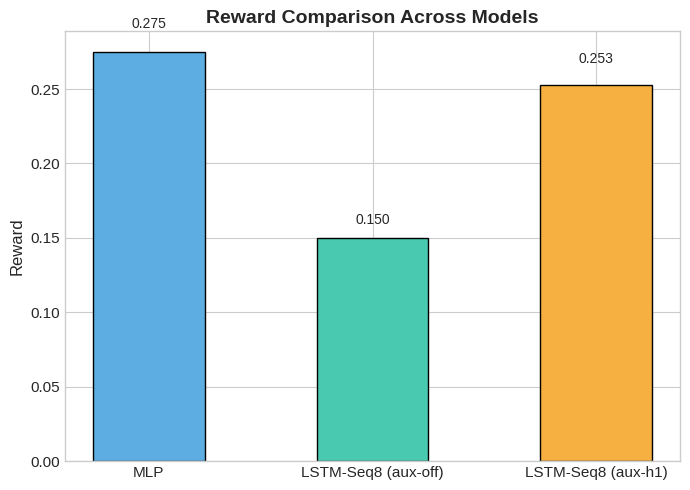

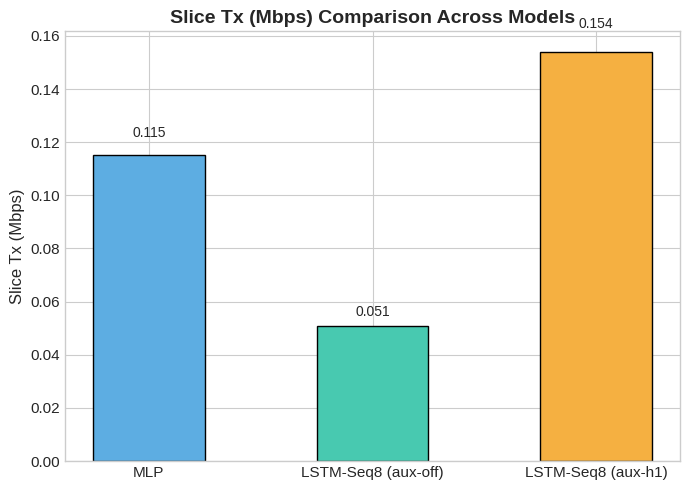

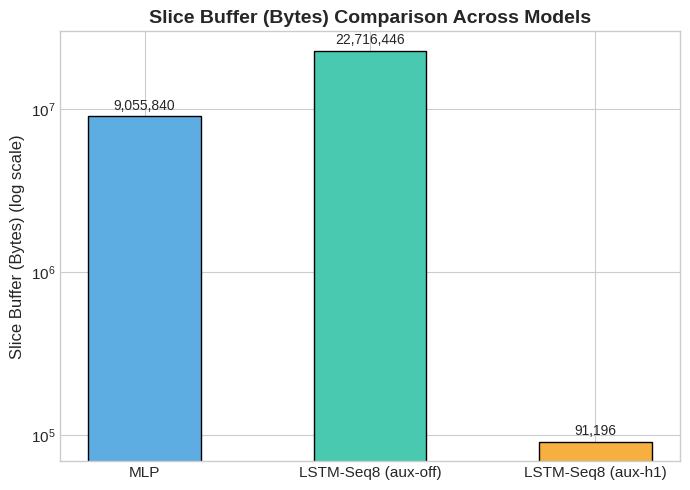

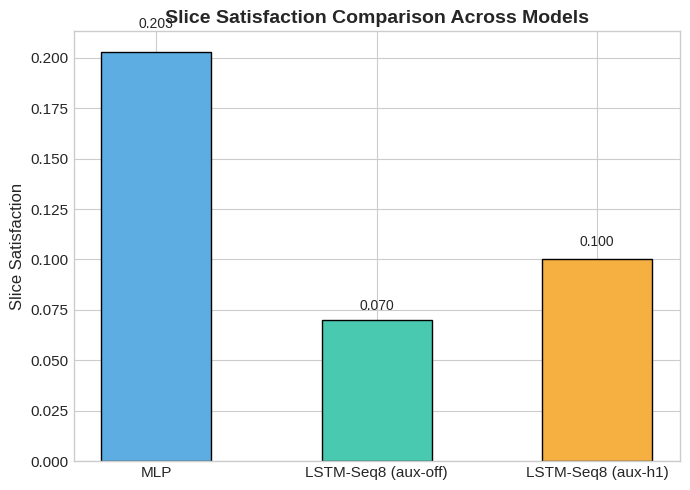

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------
# 1️⃣ Define your new data
# --------------------------------------------------
models = ["MLP", "LSTM-Seq8 (aux-off)", "LSTM-Seq8 (aux-h1)"]

metrics = {
    "Reward": [0.275, 0.150, 0.253],
    "Slice Tx (Mbps)": [0.115, 0.051, 0.154],
    "Slice Buffer (Bytes)": [9055839.631, 22716446.102, 91195.898],
    "Slice Satisfaction": [0.203, 0.070, 0.100]
}

# --------------------------------------------------
# 2️⃣ Plot each metric separately
# --------------------------------------------------
plt.style.use("seaborn-v0_8-whitegrid")

for metric_name, values in metrics.items():
    plt.figure(figsize=(7, 5))
    bars = plt.bar(
        models,
        values,
        color=["#5DADE2", "#48C9B0", "#F5B041"],
        width=0.5,
        edgecolor='black'
    )

    # Title and labels
    plt.title(f"{metric_name} Comparison Across Models", fontsize=14, fontweight='bold')
    plt.ylabel(metric_name, fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    # Optional: use log scale for large magnitude differences (like buffer bytes)
    if "Buffer" in metric_name:
        plt.yscale("log")
        plt.ylabel(f"{metric_name} (log scale)", fontsize=12)

    # Add value annotations
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval * (1.05 if yval > 0 else 0.95),
            f"{yval:.3f}" if yval < 1000 else f"{yval:,.0f}",
            ha='center', va='bottom', fontsize=10
        )

    plt.tight_layout()
    plt.show()

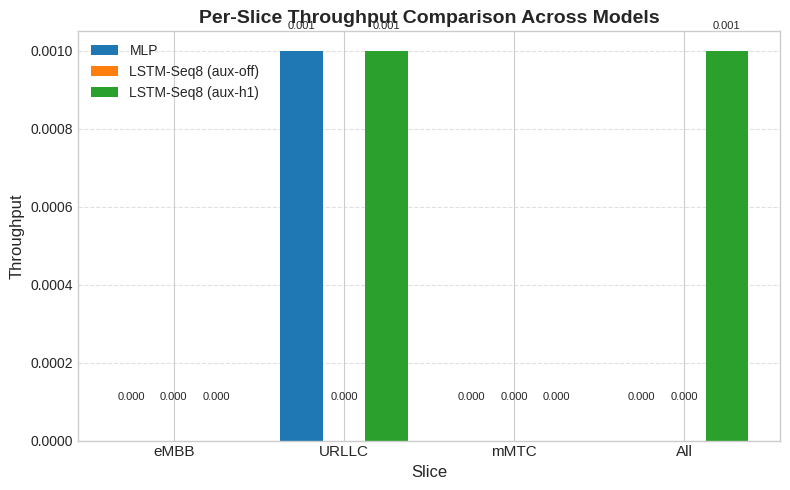

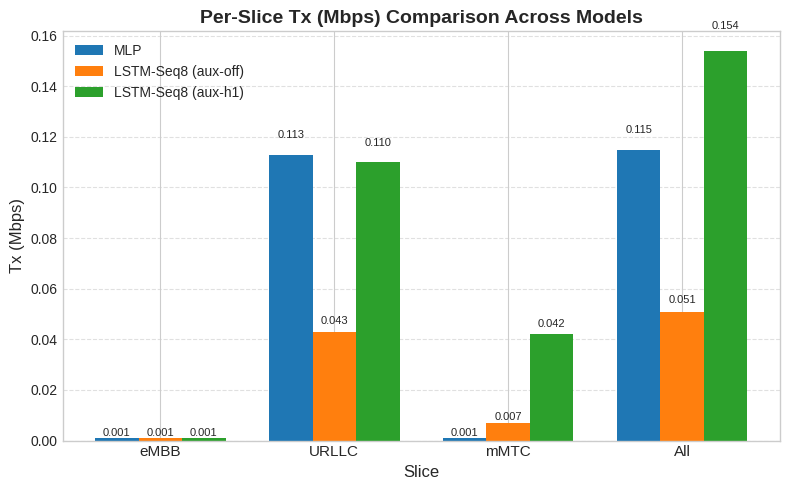

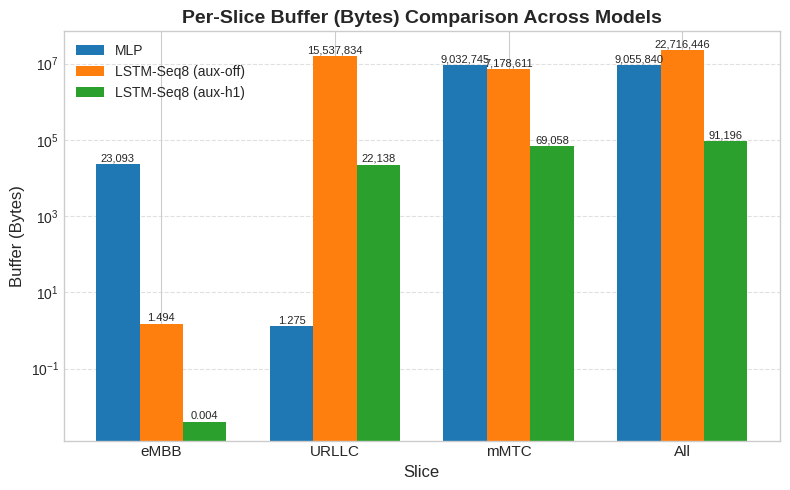

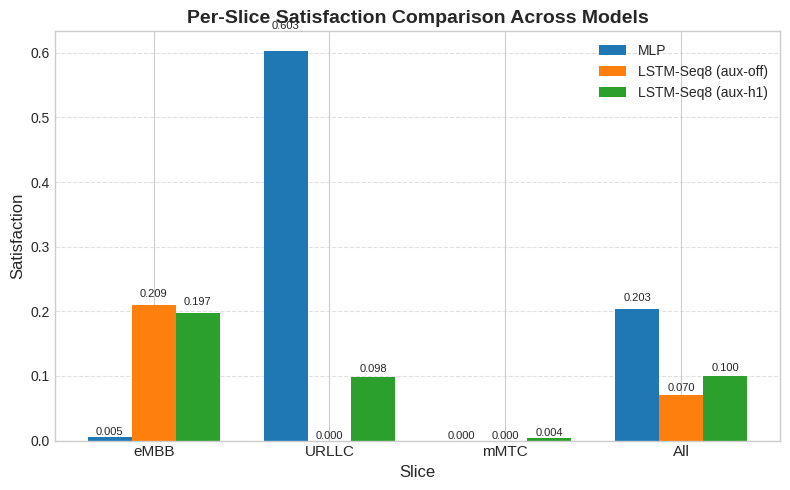

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------
# 1️⃣ Define model names and per-slice data
# --------------------------------------------------
models = ["MLP", "LSTM-Seq8 (aux-off)", "LSTM-Seq8 (aux-h1)"]
slices = ["eMBB", "URLLC", "mMTC", "All"]

# Each dictionary contains one list per model (4 values = 4 slices)
per_slice_metrics = {
    "Throughput": [
        [0.000, 0.001, 0.000, 0.000],  # MLP
        [0.000, 0.000, 0.000, 0.000],  # LSTM-Seq8 (aux-off)
        [0.000, 0.001, 0.000, 0.001],  # LSTM-Seq8 (aux-h1)
    ],
    "Tx (Mbps)": [
        [0.001, 0.113, 0.001, 0.115],  # MLP
        [0.001, 0.043, 0.007, 0.051],  # LSTM-Seq8 (aux-off)
        [0.001, 0.110, 0.042, 0.154],  # LSTM-Seq8 (aux-h1)
    ],
    "Buffer (Bytes)": [
        [23093.168, 1.275, 9032745.191, 9055839.631],  # MLP
        [1.494, 15537833.713, 7178611.044, 22716446.102],  # LSTM-Seq8 (aux-off)
        [0.004, 22137.714, 69058.180, 91195.898],  # LSTM-Seq8 (aux-h1)
    ],
    "Satisfaction": [
        [0.005, 0.603, 0.000, 0.203],  # MLP
        [0.209, 0.000, 0.000, 0.070],  # LSTM-Seq8 (aux-off)
        [0.197, 0.098, 0.004, 0.100],  # LSTM-Seq8 (aux-h1)
    ]
}

# --------------------------------------------------
# 2️⃣ Plot per-slice metrics
# --------------------------------------------------
plt.style.use("seaborn-v0_8-whitegrid")

for metric_name, model_data in per_slice_metrics.items():
    plt.figure(figsize=(8, 5))
    x = np.arange(len(slices))
    width = 0.25

    # Log scale for buffer because of large differences
    if "Buffer" in metric_name:
        plt.yscale("log")

    # Plot bars for each model
    for i, (model, values) in enumerate(zip(models, model_data)):
        plt.bar(x + i * width - width, values, width, label=model)

    # Customize
    plt.title(f"Per-Slice {metric_name} Comparison Across Models", fontsize=14, fontweight='bold')
    plt.xlabel("Slice", fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.xticks(x, slices, fontsize=11)
    plt.legend(fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.6)

    # Add value labels
    for i, (model, values) in enumerate(zip(models, model_data)):
        for j, val in enumerate(values):
            offset = val * 0.05 if val != 0 else 0.0001
            text = f"{val:.3f}" if val < 1000 else f"{val:,.0f}"
            plt.text(x[j] + i * width - width, val + offset, text,
                     ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()


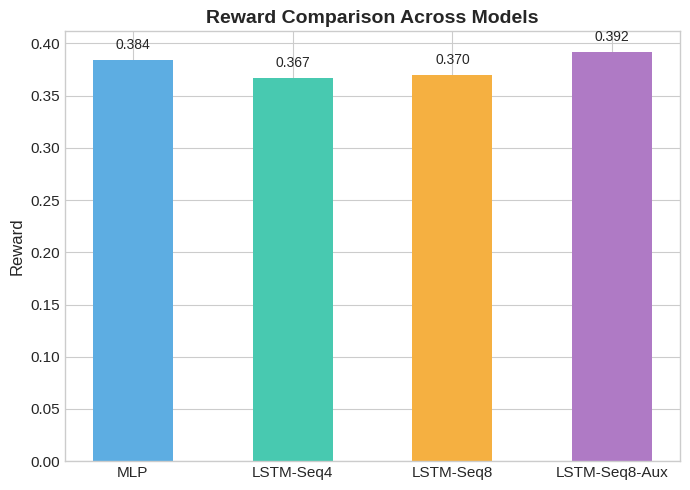

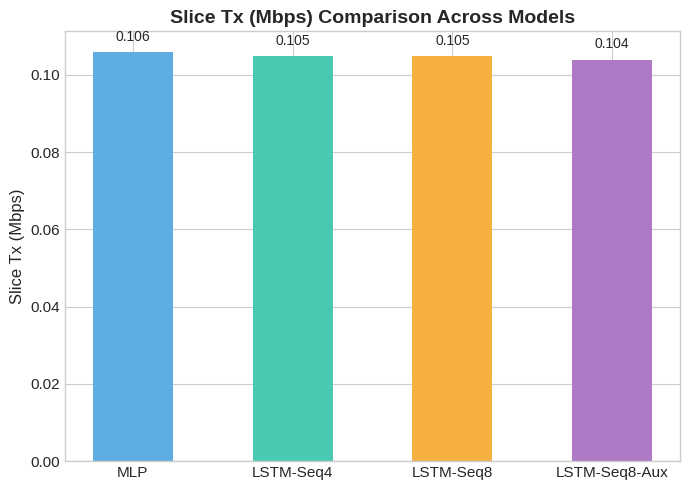

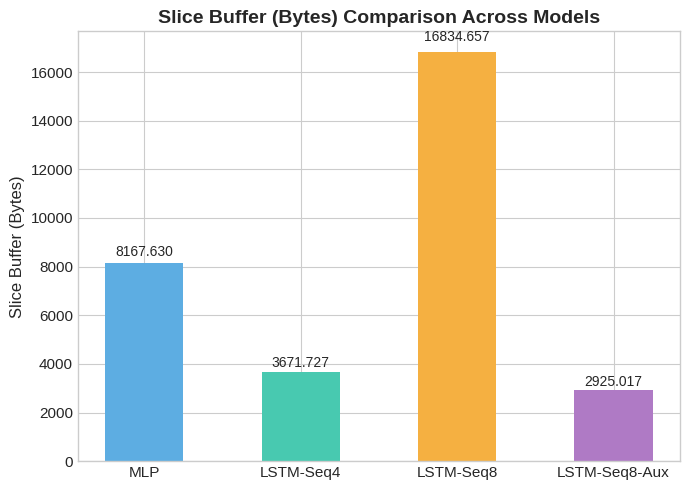

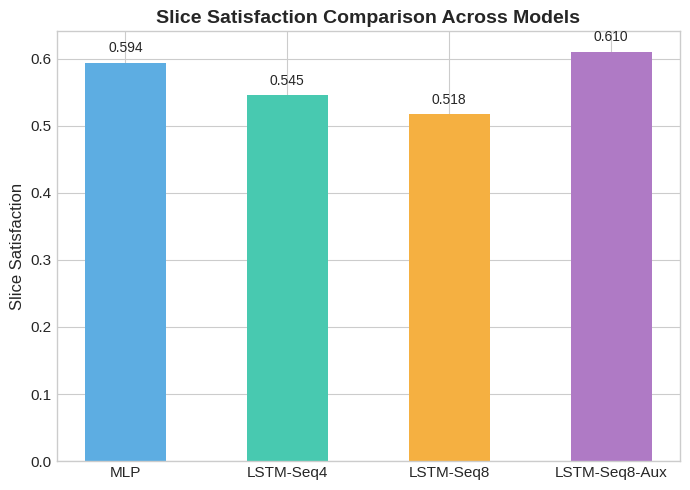

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------
# 1️⃣ Data from your experiment
# --------------------------------------------------
models = ["MLP", "LSTM-Seq4", "LSTM-Seq8", "LSTM-Seq8-Aux"]

metrics = {
    "Reward": [0.384, 0.367, 0.370, 0.392],
    "Slice Tx (Mbps)": [0.106, 0.105, 0.105, 0.104],
    "Slice Buffer (Bytes)": [8167.630, 3671.727, 16834.657, 2925.017],
    "Slice Satisfaction": [0.594, 0.545, 0.518, 0.610]
}

# --------------------------------------------------
# 2️⃣ Plot each metric separately
# --------------------------------------------------
plt.style.use("seaborn-v0_8-whitegrid")

for metric_name, values in metrics.items():
    plt.figure(figsize=(7, 5))
    bars = plt.bar(models, values, color=["#5DADE2", "#48C9B0", "#F5B041", "#AF7AC5"], width=0.5)

    # Labels and title
    plt.title(f"{metric_name} Comparison Across Models", fontsize=14, fontweight='bold')
    plt.ylabel(metric_name, fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    # Add value annotations above bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02*abs(yval), f"{yval:.3f}",
                 ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()


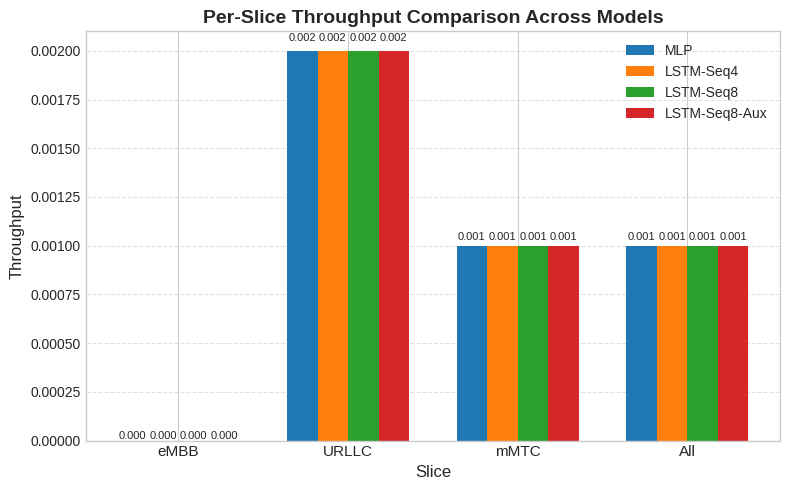

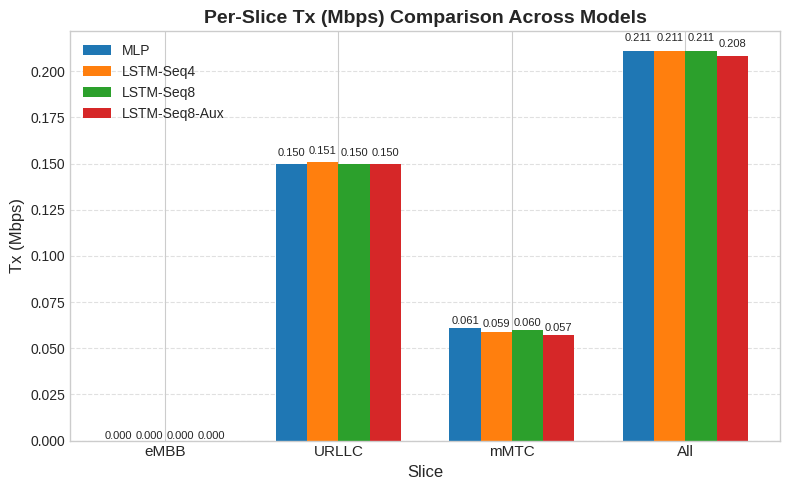

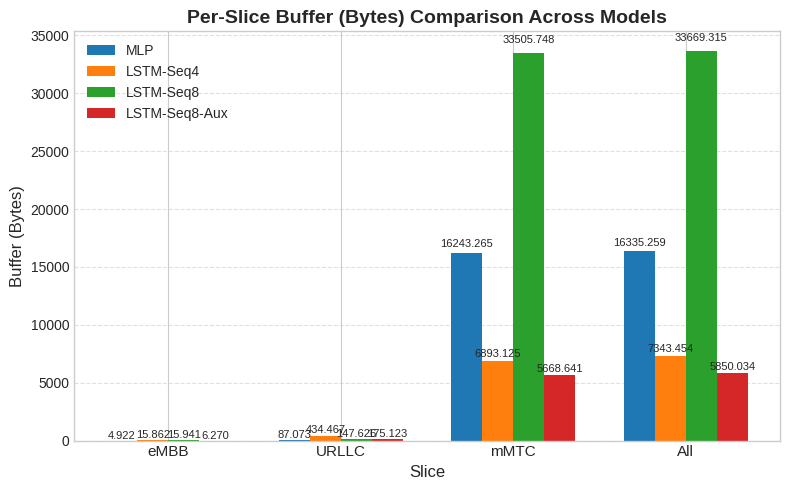

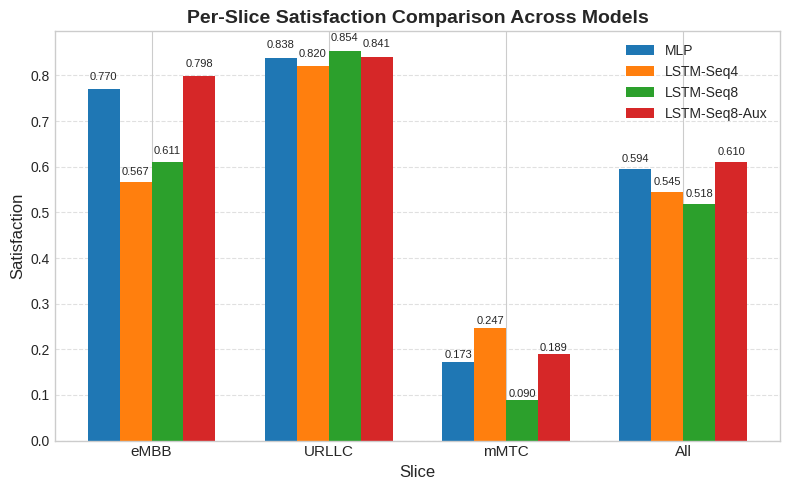

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------
# 1️⃣ Define model names and metrics
# --------------------------------------------------
models = ["MLP", "LSTM-Seq4", "LSTM-Seq8", "LSTM-Seq8-Aux"]
slices = ["eMBB", "URLLC", "mMTC", "All"]

# Each dictionary contains a list of lists (one list per model, with 4 slice values)
per_slice_metrics = {
    "Throughput": [
        [0.000, 0.002, 0.001, 0.001],  # MLP
        [0.000, 0.002, 0.001, 0.001],  # LSTM-Seq4
        [0.000, 0.002, 0.001, 0.001],  # LSTM-Seq8
        [0.000, 0.002, 0.001, 0.001],  # LSTM-Seq8-Aux
    ],
    "Tx (Mbps)": [
        [0.000, 0.150, 0.061, 0.211],  # MLP
        [0.000, 0.151, 0.059, 0.211],  # LSTM-Seq4
        [0.000, 0.150, 0.060, 0.211],  # LSTM-Seq8
        [0.000, 0.150, 0.057, 0.208],  # LSTM-Seq8-Aux
    ],
    "Buffer (Bytes)": [
        [4.922, 87.073, 16243.265, 16335.259],  # MLP
        [15.862, 434.467, 6893.125, 7343.454],  # LSTM-Seq4
        [15.941, 147.626, 33505.748, 33669.315],  # LSTM-Seq8
        [6.270, 175.123, 5668.641, 5850.034],  # LSTM-Seq8-Aux
    ],
    "Satisfaction": [
        [0.770, 0.838, 0.173, 0.594],  # MLP
        [0.567, 0.820, 0.247, 0.545],  # LSTM-Seq4
        [0.611, 0.854, 0.090, 0.518],  # LSTM-Seq8
        [0.798, 0.841, 0.189, 0.610],  # LSTM-Seq8-Aux
    ]
}

# --------------------------------------------------
# 2️⃣ Plot per-slice metrics
# --------------------------------------------------
plt.style.use("seaborn-v0_8-whitegrid")

for metric_name, model_data in per_slice_metrics.items():
    plt.figure(figsize=(8, 5))
    x = np.arange(len(slices))
    width = 0.18

    # Plot bars for each model
    for i, (model, values) in enumerate(zip(models, model_data)):
        plt.bar(x + i*width - width*1.5, values, width, label=model)

    # Customize
    plt.title(f"Per-Slice {metric_name} Comparison Across Models", fontsize=14, fontweight='bold')
    plt.xlabel("Slice", fontsize=12)
    plt.ylabel(metric_name, fontsize=12)
    plt.xticks(x, slices, fontsize=11)
    plt.legend(fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.6)

    # Add value labels
    for i, (model, values) in enumerate(zip(models, model_data)):
        for j, val in enumerate(values):
            plt.text(x[j] + i*width - width*1.5, val + 0.02*abs(val), f"{val:.3f}",
                     ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()
